### Домашнее задание 2

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

In [1]:
!pip install gensim

In [2]:
!pip install razdel

In [3]:
!pip install pymorphy2

In [4]:
!pip install nltk

In [5]:
import pandas as pd

Загрузим пользователей и списки последних прочитанных новостей

Новости

In [6]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Юзеры

In [7]:
users = pd.read_csv('/Users/andrewvolkov/Documents/Study/ML_in_BUS/data/users_articles.csv')
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [8]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

/Applications/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewvolkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-12-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 35.4 s, sys: 497 ms, total: 35.9 s
Wall time: 36.3 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 37s, sys: 2.14 s, total: 4min 39s
Wall time: 4min 49s


А теперь в 3 строчки обучим нашу модель

In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [16]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 19s, sys: 997 ms, total: 1min 20s
Wall time: 52.2 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.24255036),
 (7, 0.14043568),
 (11, 0.10041668),
 (16, 0.08077105),
 (22, 0.41464466)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: пенсия район учреждение педагог опрос индустрия подмосковье
topic_1: млн рубль цена размер стоимость сша доход
topic_2: санкция глава рейс медведев выборы белый государство
topic_3: рак активность доклад достигать польша живой грант
topic_4: банк nn депутат совет государственный рф федеральный
topic_5: налог исследование лаборатория градус физика составить годовой
topic_6: население иск городской россия смерть сотрудничество визит
topic_7: тыс район около станция пострадать квартира час
topic_8: фонд участник фестиваль мероприятие область nn россия
topic_9: исследование женщина автор пациент мужчина планета nn
topic_10: россия российский украина система nn всё источник
topic_11: инвестиция проверка лечение врач больница офицер доказательство
topic_12: русский земля армия памятник завод отряд кожа
topic_13: проект наука москва фонд территория строительство россия
topic_14: путин препарат владимир пресссекретарить песок лекарство кремль
topic_15: статья операция обнаружить остро

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.083019,0.853780,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.036610,0.0,0.0,0.018696,0.000000,0.0
1,4896,0.0,0.0,0.0,0.323510,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.652266,0.0
2,4897,0.0,0.0,0.0,0.242549,0.000000,0.0,0.0,0.140439,0.000000,...,0.000000,0.080766,0.0,0.0,0.000000,0.0,0.0,0.414647,0.000000,0.0
3,4898,0.0,0.0,0.0,0.060311,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.096504,0.0,0.0,0.832131,0.000000,0.0
4,4899,0.0,0.0,0.0,0.000000,0.451077,0.0,0.0,0.000000,0.115582,...,0.266564,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13003448, 0.0485402 , 0.        , 0.        , 0.06038799,
       0.09905741, 0.        , 0.        , 0.05195242, 0.12513547,
       0.        , 0.        , 0.02921192, 0.        , 0.04523348,
       0.        , 0.        , 0.22805861, 0.17219672, 0.        ])

In [26]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [27]:
get_user_embedding(user_articles_list)

array([0.        , 0.01993038, 0.04464474, 0.        , 0.08869594,
       0.        , 0.00689928, 0.00484964, 0.04449028, 0.02822992,
       0.17466098, 0.01404796, 0.01444141, 0.02208171, 0.05542312,
       0.01995197, 0.06586913, 0.06645829, 0.09093974, 0.09329828,
       0.0077946 , 0.07008941, 0.03863448, 0.0152853 , 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [28]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [29]:
# " ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.051389,0.036783,0.014567,0.025983,0.013161,0.098150,0.028704,...,0.011979,0.124782,0.014161,0.035140,0.056106,0.000000,0.013701,0.040303,0.100671,0.034550
1,u108690,0.002928,0.003192,0.059713,0.015890,0.023062,0.005584,0.027299,0.020961,0.035934,...,0.000000,0.029280,0.035924,0.043942,0.044649,0.000000,0.055099,0.108248,0.102788,0.014966
2,u108339,0.000000,0.015263,0.041895,0.000000,0.037863,0.004330,0.006217,0.093126,0.078869,...,0.045727,0.019381,0.043367,0.044233,0.111224,0.002679,0.026205,0.068209,0.083086,0.006755


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [31]:
target = pd.read_csv('/Users/andrewvolkov/Documents/Study/ML_in_BUS/data/users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.051389,0.036783,0.014567,0.025983,0.013161,0.098150,0.028704,...,0.124782,0.014161,0.035140,0.056106,0.000000,0.013701,0.040303,0.100671,0.034550,0
1,u108690,0.002928,0.003192,0.059713,0.015890,0.023062,0.005584,0.027299,0.020961,0.035934,...,0.029280,0.035924,0.043942,0.044649,0.000000,0.055099,0.108248,0.102788,0.014966,1
2,u108339,0.000000,0.015263,0.041895,0.000000,0.037863,0.004330,0.006217,0.093126,0.078869,...,0.019381,0.043367,0.044233,0.111224,0.002679,0.026205,0.068209,0.083086,0.006755,1


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [35]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15083924, 0.18457476, 0.46110986, 0.04948008, 0.03947556,
       0.04650416, 0.13432902, 0.08256819, 0.11388543, 0.13218435])

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.251499, F-Score=0.650, Precision=0.603, Recall=0.706


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1641  114]
 [  73  172]]


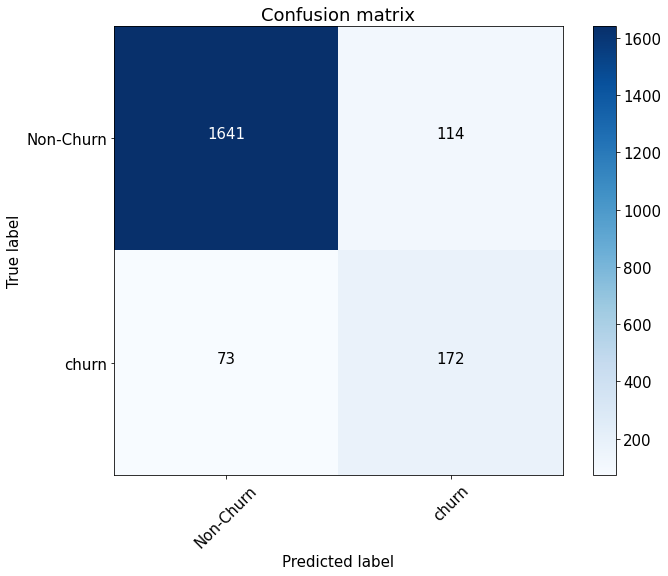

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
roc_auc_score(y_test, preds)

0.9386778301064016

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

##### сохраним предыдущие результаты

In [42]:
precision_mean = precision[ix]

In [43]:
recall_mean = recall[ix]

In [44]:
fscore_mean = fscore[ix]

In [45]:
ras_mean = roc_auc_score(y_test, preds)

##### добавил в функцию параметр function.

In [46]:
def get_user_embedding(user_articles_list, function):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = function(user_vector, 0) # добавлен параметр function
    return user_vector

##### используем np.median

In [47]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.median), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,0.000000,0.030683,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.126269,0.000000
1,u108690,0.0,0.0,0.051807,0.0,0.011381,0.0,0.019384,0.011411,0.00000,...,0.000000,0.006410,0.026468,0.016155,0.039148,0.0,0.041238,0.094444,0.102249,0.000000
2,u108339,0.0,0.0,0.000000,0.0,0.025706,0.0,0.000000,0.022239,0.06008,...,0.020947,0.014953,0.013165,0.014128,0.103020,0.0,0.000000,0.045770,0.102281,0.005368


In [48]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,0.030683,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.126269,0.000000,0
1,u108690,0.0,0.0,0.051807,0.0,0.011381,0.0,0.019384,0.011411,0.00000,...,0.006410,0.026468,0.016155,0.039148,0.0,0.041238,0.094444,0.102249,0.000000,1
2,u108339,0.0,0.0,0.000000,0.0,0.025706,0.0,0.000000,0.022239,0.06008,...,0.014953,0.013165,0.014128,0.103020,0.0,0.000000,0.045770,0.102281,0.005368,1


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [50]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [51]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10206937, 0.03316557, 0.59372384, 0.10980203, 0.00738724,
       0.06497515, 0.19526093, 0.05138181, 0.05327266, 0.15719477])

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.268922, F-Score=0.800, Precision=0.763, Recall=0.841


In [53]:
precision_median = precision[ix]
recall_median = recall[ix]
fscore_median = fscore[ix]
ras_median = roc_auc_score(y_test, preds)

##### используем np.max

In [54]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.280461,0.220695,0.087403,0.130034,0.048540,0.381074,0.136719,...,0.071872,0.489369,0.055754,0.106075,0.291401,0.000000,0.082203,0.228059,0.179291,0.125879
1,u108690,0.017571,0.019151,0.154731,0.095339,0.078506,0.021728,0.087613,0.051596,0.143765,...,0.000000,0.126972,0.112899,0.165273,0.106049,0.000000,0.125038,0.276979,0.195402,0.089797
2,u108339,0.000000,0.055589,0.182058,0.000000,0.098336,0.013583,0.019563,0.297508,0.206300,...,0.205616,0.053438,0.200869,0.150537,0.281064,0.016074,0.157231,0.196762,0.128388,0.018166


In [55]:
X = pd.merge(user_embeddings, target, 'left')

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [57]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [58]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12582738, 0.01304487, 0.69028843, 0.02188934, 0.01476638,
       0.01393199, 0.01158511, 0.03458658, 0.01233067, 0.09620945])

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.336293, F-Score=0.777, Precision=0.766, Recall=0.788


In [60]:
precision_max = precision[ix]
recall_max = recall[ix]
fscore_max = fscore[ix]
ras_max = roc_auc_score(y_test, preds)


##### Итоговая таблица метрик

In [62]:
results = {'Embedding' : ['Mean', 'Median', 'Max'],
          'Precisiion': [precision_mean, precision_median, precision_max],
          'Recall': [recall_mean, recall_median, recall_max],
          'Fscore': [fscore_mean, fscore_median, fscore_max],
          'Roc Auc Score': [ras_mean, ras_median, ras_max]}

result_df = pd.DataFrame(results)
result_df = result_df.set_index('Embedding')
result_df

,Precisiion,Recall,Fscore,Roc Auc Score
Embedding,,,,
Mean,0.602787,0.706122,0.650376,0.938678
Median,0.762963,0.840816,0.800000,0.980420
Max,0.765873,0.787755,0.776660,0.967696


<Figure size 432x288 with 0 Axes>

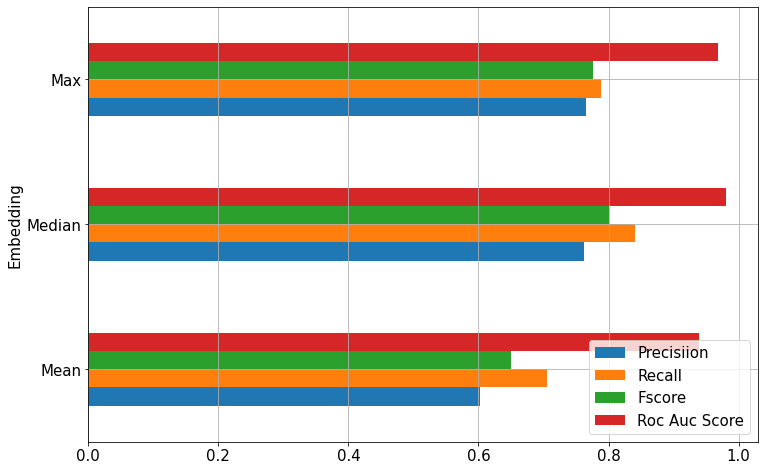

In [63]:
plt.figure()
result_df.plot(kind='barh', figsize=(12, 8))
plt.grid()


##### посмотрим на эмбединги с каждой из функций

In [76]:
get_user_embedding(user_articles_list, np.mean)

array([0.        , 0.01993038, 0.04464474, 0.        , 0.08869594,
       0.        , 0.00689928, 0.00484964, 0.04449028, 0.02822992,
       0.17466098, 0.01404796, 0.01444141, 0.02208171, 0.05542312,
       0.01995197, 0.06586913, 0.06645829, 0.09093974, 0.09329828,
       0.0077946 , 0.07008941, 0.03863448, 0.0152853 , 0.        ])

In [77]:
get_user_embedding(user_articles_list, np.max)

array([0.        , 0.1195823 , 0.26786843, 0.        , 0.33439848,
       0.        , 0.04139569, 0.02909784, 0.15015027, 0.11578614,
       0.56528926, 0.08428777, 0.0462278 , 0.09748285, 0.23364763,
       0.09025325, 0.19295585, 0.2470261 , 0.35132155, 0.34707013,
       0.03150214, 0.21574596, 0.10939298, 0.05887489, 0.        ])

In [67]:
get_user_embedding(user_articles_list, np.median)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00887769, 0.01095732,
       0.13671083, 0.        , 0.        , 0.        , 0.0056569 ,
       0.        , 0.03365066, 0.02877522, 0.02449951, 0.        ,
       0.        , 0.03062846, 0.03054439, 0.        , 0.        ])

Лучший результат дает использование функции np.median. При использовании этой функции в векторном представлении "интересов" пользователя остаются только наиболее просматриваемые топики, что возможно позволяет более точно предсказывать отток пользователей.